In [ ]:
import csv
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from collections import deque
import random
import itertools
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install scikit-optimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.6 MB/s eta 0:00:00


In [ ]:
# Direct download URL for the Google Drive file
CSV_URL = 'https://drive.google.com/uc?export=download&id=1K2zmMuv0mj-vTdVmL7skUD_uFND0gg0U'

try:
    # Read the CSV file directly into a DataFrame
    adult_dataset = pd.read_csv(CSV_URL)
except Exception as e:
    print("Error reading the CSV file:", e)


In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.2 MB/s eta 0:00:00


Episode 1/10 completed.
Episode 2/10 completed.
Episode 3/10 completed.
Episode 4/10 completed.
Episode 5/10 completed.
Episode 6/10 completed.
Episode 7/10 completed.
Episode 8/10 completed.
Episode 9/10 completed.
Episode 10/10 completed.
Evaluation Accuracy: 79.53%
Confusion Matrix:
[[1806  536]
 [ 421 1912]]


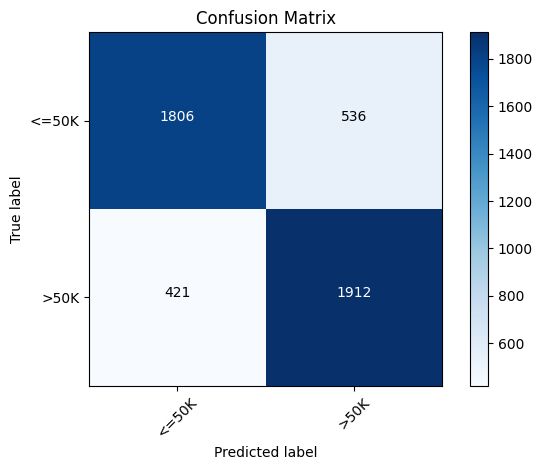


Classification Report:
              precision    recall  f1-score   support

       <=50K       0.81      0.77      0.79      2342
        >50K       0.78      0.82      0.80      2333

    accuracy                           0.80      4675
   macro avg       0.80      0.80      0.80      4675
weighted avg       0.80      0.80      0.80      4675



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import deque
import random
import itertools
import matplotlib.pyplot as plt

data = adult_dataset

# Define features and target
X = data.drop(columns=['income'])
y = data['income']

# Feature scaling
scaler = standardscaler()
X_scaled = scaler.fit_transform(X)


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.int64)
y_test = torch.tensor(y_test.values, dtype=torch.int64)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        self.update_target_network()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.model(states).gather(1, actions.view(-1, 1)).squeeze()
        next_q_values = self.target_model(next_states).max(1)[0]
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_dqn_agent(agent, X_train, y_train, n_episodes, target_update_freq):
    for episode in range(n_episodes):
        for idx in range(len(X_train)):
            state = X_train[idx].numpy()
            action = agent.act(state)
            reward = 1 if action == y_train[idx].item() else -1
            next_state = state
            done = True
            agent.remember(state, action, reward, next_state, done)
            agent.replay()

        if episode % target_update_freq == 0:
            agent.update_target_network()
        print(f"Episode {episode + 1}/{n_episodes} completed.")

def evaluate_dqn_agent(agent, X_test, y_test):
    y_pred = []
    for idx in range(len(X_test)):
        state = X_test[idx].numpy()
        action = agent.act(state)
        y_pred.append(action)
    accuracy = np.mean(np.array(y_pred) == y_test.numpy())
    print(f"Evaluation Accuracy: {accuracy * 100:.2f}%")
    return y_pred

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Hyperparameters
state_dim = X_train.shape[1]
action_dim = 2  # Binary classification (0 or 1)
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
memory_size = 2000
batch_size = 64
n_episodes = 10
target_update_freq = 10

agent = DQNAgent(state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size)

# Train the agent
train_dqn_agent(agent, X_train, y_train, n_episodes, target_update_freq)

# Evaluate the agent
y_pred = evaluate_dqn_agent(agent, X_test, y_test)

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plot_confusion_matrix(cm, classes=['<=50K', '>50K'], title='Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

rent dataset

In [ ]:
import pandas as pd

# Direct download URL for the Google Drive file
CSV_URL = 'https://drive.google.com/uc?export=download&id=1iyhG9KK2SpLS1BxP6axyTMZw7RMjWgwR'

try:
    # Read the CSV file directly into a DataFrame
    rent_apartments_dataset = pd.read_csv(CSV_URL)
except Exception as e:
    print("Error reading the CSV file:", e)

In [ ]:
pip install scikit-optimize


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import deque
import random
from skopt import gp_minimize
from skopt.space import Real, Integer


target_column = 'price'

# Prepare data
X = rent_apartments_dataset.drop(columns=[target_column])
y = rent_apartments_dataset[target_column]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Custom Neural Network Class
class CustomDQN(nn.Module):
    def __init__(self, input_dim, dropout_rate):
        super(CustomDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.dropout(self.tanh(self.fc2(x)))
        x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

# DQN Agent Class
class DQNAgent:
    def __init__(self, state_dim, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size, dropout_rate):
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = CustomDQN(state_dim, dropout_rate)
        self.target_model = CustomDQN(state_dim, dropout_rate)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.95)
        self.criterion = nn.MSELoss()
        self.update_target_network()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, reward, next_state, done):
        self.memory.append((state, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.rand()
        state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            return self.model(state).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, rewards, next_states, dones = zip(*minibatch)
        states, rewards, next_states, dones = map(torch.tensor, (states, rewards, next_states, dones))

        # Convert dones to float tensor
        dones = dones.float()

        q_values = self.model(states)
        next_q_values = self.target_model(next_states).detach()
        target_q_values = rewards.view(-1, 1) + self.gamma * next_q_values * (1 - dones.view(-1, 1))

        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

# Training Function
def train_dqn_agent(agent, X_train, y_train, n_episodes, target_update_freq, min_memory_size):
    loss_history = []
    for episode in range(n_episodes):
        for idx in range(len(X_train)):
            state = X_train[idx].numpy()
            reward = y_train[idx].item()
            next_state = state
            done = True
            agent.remember(state, reward, next_state, done)
            if len(agent.memory) >= min_memory_size:
                loss = agent.replay()

        if episode % target_update_freq == 0:
            agent.update_target_network()
        print(f"Episode {episode + 1}/{n_episodes} completed.")
        if len(agent.memory) >= min_memory_size:
            loss_history.append(loss)
    return loss_history

# Evaluation Function
def evaluate_dqn_agent(agent, X_test, y_test):
    agent.model.eval()
    y_pred = [agent.act(X_test[idx].unsqueeze(0).numpy()) for idx in range(len(X_test))]
    y_pred = np.array(y_pred).reshape(-1, 1)
    mse = mean_squared_error(y_test.numpy(), y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test.numpy(), y_pred)
    print(f"Evaluation MSE: {mse:.4f}")
    print(f"Evaluation RMSE: {rmse:.4f}")
    print(f"Evaluation MAE: {mae:.4f}")
    agent.model.train()
    return mse

# Bayesian Optimization
space = [
    Real(1e-4, 1e-2, name='learning_rate'),
    Integer(32, 256, name='batch_size'),
    Real(0.1, 0.5, name='dropout_rate'),
    Real(0.9, 0.999, name='gamma'),
    Real(0.99, 1.0, prior='log-uniform', name='epsilon_decay'),
    Integer(5, 20, name='target_update_freq')
]

def objective(params):
    learning_rate, batch_size, dropout_rate, gamma, epsilon_decay, target_update_freq = params
    agent = DQNAgent(X_train.shape[1], learning_rate, gamma, 1.0, epsilon_decay, 0.01, 5000, batch_size, dropout_rate)
    train_dqn_agent(agent, X_train, y_train, n_episodes=20, target_update_freq=target_update_freq, min_memory_size=1000)
    mse = evaluate_dqn_agent(agent, X_test, y_test)
    print(f"Tested hyperparameters: learning_rate={learning_rate}, batch_size={batch_size}, dropout_rate={dropout_rate}, gamma={gamma}, epsilon_decay={epsilon_decay}, target_update_freq={target_update_freq}")
    print(f"Resulting MSE: {mse:.4f}")
    return mse

# Run Bayesian optimization
res = gp_minimize(objective, space, n_calls=10, random_state=42)


Episode 1/20 completed.
Episode 2/20 completed.
Episode 3/20 completed.
Episode 4/20 completed.
Episode 5/20 completed.
Episode 6/20 completed.
Episode 7/20 completed.
Episode 8/20 completed.
Episode 9/20 completed.
Episode 10/20 completed.
Episode 11/20 completed.
Episode 12/20 completed.
Episode 13/20 completed.
Episode 14/20 completed.
Episode 15/20 completed.
Episode 16/20 completed.
Episode 17/20 completed.
Episode 18/20 completed.
Episode 19/20 completed.
Episode 20/20 completed.
Evaluation MSE: 0.4893
Evaluation RMSE: 0.6995
Evaluation MAE: 0.5133
Tested hyperparameters: learning_rate=0.007985775569916307, batch_size=73, dropout_rate=0.41187640010910787, gamma=0.9590881656367022, epsilon_decay=0.9944459143305066, target_update_freq=6
Resulting MSE: 0.4893
Episode 1/20 completed.
Episode 2/20 completed.
Episode 3/20 completed.
Episode 4/20 completed.
Episode 5/20 completed.
Episode 6/20 completed.
Episode 7/20 completed.
Episode 8/20 completed.
Episode 9/20 completed.
Episode 10/

Best hyperparameters: Learning rate: 0.006835044632019021, Batch size: 133, Dropout rate: 0.10530598446394662, Gamma: 0.9932779738128005, Epsilon decay: 0.9956205179412967, Target update freq: 11